In [24]:
import numpy as np
import dgl
from dgl.dataloading.dataloader import NodeCollator
from dgl.dataloading.pytorch import NodeDataLoader
import torch

In [60]:
r_node = np.random.randint(0,20,50)
d_node = np.random.randint(0,20,50)
edge = set(zip(r_node, d_node))

In [61]:
src, dst = tuple(zip(*edge))

In [62]:
g = dgl.DGLGraph()
g.add_nodes(20)

/home/haoquan/anaconda3/envs/maxp_dgl/lib/python3.8/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [63]:
g.add_edges(src, dst)

In [82]:
g.in_degrees()

tensor([3, 3, 5, 2, 1, 3, 3, 2, 4, 4, 0, 0, 1, 4, 6, 0, 1, 2, 2, 2])

In [64]:
g_b = dgl.to_bidirected(g, copy_ndata=True)

In [65]:
g_r = dgl.reverse(g, copy_ndata=True)

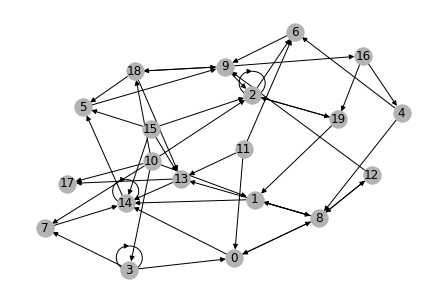

In [66]:
import networkx as nx
nx_G = g.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

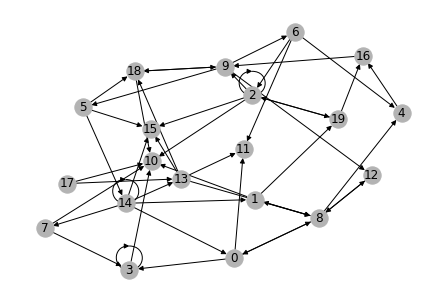

In [67]:
import networkx as nx
nx_G = g_r.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

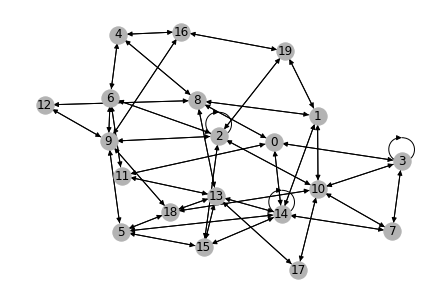

In [68]:
import networkx as nx
nx_G = g_b.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [69]:
from dgl.dataloading.neighbor import MultiLayerNeighborSampler
sampler1 =  MultiLayerNeighborSampler(fanouts=[-1,-1])
train_nid = range(10)
dataloader1 = NodeDataLoader(g_b,
                            train_nid,
                            sampler1,
                            batch_size=2,
                            shuffle=False,
                            drop_last=False,
                            num_workers=4)
for  batch in dataloader1:
    input_nodes, output_nodes, blocks = batch
    print(batch)
    break

(tensor([ 0,  1,  3,  8, 11, 14, 10, 19,  7,  4, 12, 13,  6,  5, 15,  2, 17, 18,
        16]), tensor([0, 1]), [Block(num_src_nodes=19, num_dst_nodes=8, num_edges=36), Block(num_src_nodes=8, num_dst_nodes=2, num_edges=8)])


In [14]:
dataloader1 = NodeDataLoader(g,
                            train_nid,
                            sampler1,
                            batch_size=2,
                            shuffle=False,
                            drop_last=False,
                            num_workers=4)
for  batch in dataloader1:
    input_nodes, output_nodes, blocks = batch
    print(batch)
    break

[tensor([ 0,  1,  3,  5,  2, 13,  7,  6,  8, 10, 14, 19]), tensor([0, 1]), [Block(num_src_nodes=12, num_dst_nodes=6, num_edges=12), Block(num_src_nodes=6, num_dst_nodes=2, num_edges=4)]]


In [70]:
g_1 = dgl.sampling.sample_neighbors(g, [0,1], 2, edge_dir='in')
g_2 = dgl.sampling.sample_neighbors(g_r, [0,1], 2, edge_dir='in')

In [71]:

src_1, dst_1 = g_1.all_edges()
src_2, dst_2 = g_2.all_edges()
src = torch.cat((src_1, src_2),dim=-1)
dst = torch.cat((dst_1, dst_2),dim=-1)
g_3 = dgl.graph((src, dst), num_nodes=g.number_of_nodes())

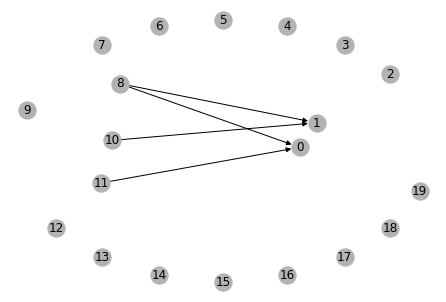

In [72]:
nx_G = g_1.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

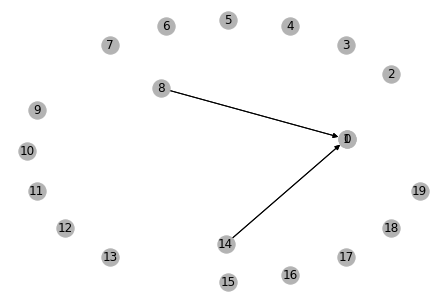

In [73]:
nx_G = g_2.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

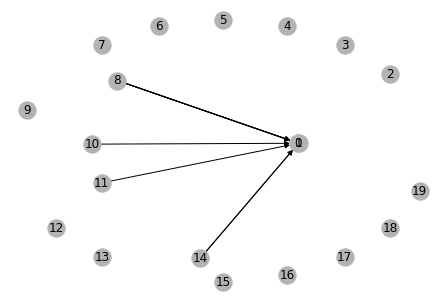

In [74]:
nx_G = g_3.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [75]:
class MultiLayerInOutSampler(dgl.dataloading.BlockSampler):
    def __init__(self, num_layers, in_fanouts, out_fanouts, return_eids=False, output_ctx=None):
        super().__init__(num_layers, return_eids=return_eids, output_ctx=output_ctx)
        self.in_fanouts = in_fanouts
        self.out_fanouts = out_fanouts

    def sample_frontier(self, block_id, g, seed_nodes):
        # 出入分别采样
        in_fanouts, out_fanouts = self.in_fanouts[block_id], self.out_fanouts[block_id]
        in_frontier = dgl.sampling.sample_neighbors(g, seed_nodes, in_fanouts, edge_dir='in')
        out_frontier = dgl.sampling.sample_neighbors(g, seed_nodes, out_fanouts, edge_dir='out')
        in_src, in_det = in_frontier.all_edges()
        out_src, out_det = out_frontier.all_edges()
        src = torch.cat((in_src, out_det), dim=-1)
        det = torch.cat((in_det, out_src), dim=-1)
        frontier = dgl.graph((src, det), num_nodes=g.number_of_nodes())
        return frontier
    
    def __len__(self):
        return self.num_layers

In [77]:
sampler =  MultiLayerInOutSampler(num_layers=2, in_fanouts=[1,1], out_fanouts=[1,1])
train_nid = range(10)
dataloader = NodeDataLoader(g_r,
                            train_nid,
                            sampler,
                            batch_size=2,
                            shuffle=False,
                            drop_last=False,
                            num_workers=4)
for  batch in dataloader:
    input_nodes, output_nodes, blocks = batch
    print(batch)
    break

(tensor([ 0,  1, 14,  8, 11, 19, 12,  2, 15,  4]), tensor([0, 1]), [Block(num_src_nodes=10, num_dst_nodes=6, num_edges=11), Block(num_src_nodes=6, num_dst_nodes=2, num_edges=4)])


In [24]:
sampler2 =  MultiLayerInOutSampler(num_layers=2, in_fanouts=[-1,-1], out_fanouts=[-1,-1])
train_nid = range(10)
dataloader2 = NodeDataLoader(g_r,
                            train_nid,
                            sampler2,
                            batch_size=2,
                            shuffle=False,
                            drop_last=False,
                            num_workers=4)
for  batch in dataloader2:
    input_nodes, output_nodes, blocks = batch
    print(batch)
    break

[tensor([ 0,  1,  4,  9, 11, 19]), tensor([0, 1]), [Block(num_src_nodes=6, num_dst_nodes=3, num_edges=4), Block(num_src_nodes=3, num_dst_nodes=2, num_edges=1)]]


In [25]:
import torch
sampler2.sample_blocks(g,torch.tensor([0,1,2]))

[Block(num_src_nodes=14, num_dst_nodes=8, num_edges=16),
 Block(num_src_nodes=8, num_dst_nodes=3, num_edges=6)]

In [42]:
from dgl.dataloading.neighbor import MultiLayerNeighborSampler
from dgl.dataloading.pytorch import NodeDataLoader
import random

# print(train_nid)
# train_nid = list(set(train_nid))
# print(train_nid)

In [84]:
import numpy as np
data = np.load('dataset/features_neigh01.npy')

In [87]:
data[:10]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.17403358, 0.13925916, 0.21048357, 0.06976511, 0.48826662,
        0.09881183, 0.24853173, 0.04388716],
       [0.07544453, 0.10848714, 0.2617531 , 0.06491703, 0.4594309 ,
        0.09019325, 0.2447737 , 0.06915585],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.10863471, 0.1608309 , 0.23290959, 0.0996237 , 0.25950024,
        0.11302025, 0.168458  , 0.13352458],
       [0.        , 0.        , 0.        , 0.        , 0.4924685 ,
        0.05976297, 0.2992049 , 0.06846349],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.20878193, 0.04559144, 0.5121029 ,
        0.14348137, 0.29615092, 0.04505325],
       [0.02387063, 0.04134515, 0.2313766 , 0.05654223, 0.33579054,
        0.07290412, 0.164732

In [115]:
class MultiLayerProbsSampler(dgl.dataloading.BlockSampler):
    def __init__(self, probs, max_fanouts, num_layers):
        super().__init__(num_layers)
        self.probs = probs
        self.max_fanouts = max_fanouts

    def sample_frontier(self, block_id, g, seed_nodes, *args, **kwargs):
        max_fanout = self.max_fanouts[block_id]
        prob = self.probs[block_id]

        # 保证边的个数小于
        src, dst = dgl.sampling.sample_neighbors(g, seed_nodes, max_fanout).all_edges()

        # 以概率p随机选择边
        mask = torch.zeros_like(src).bernoulli_(prob)==1
        
        src = src[mask]
        dst = dst[mask]
        # 返回一个与初始图有相同节点的边界
        frontier = dgl.graph((src, dst), num_nodes=g.number_of_nodes())
        return frontier

    def __len__(self):
        return self.num_layers


class MultiLayerFullNeighborSampler(dgl.dataloading.BlockSampler):
    def __init__(self, n_layers):
        super().__init__(n_layers)

    def sample_frontier(self, block_id, g, seed_nodes):
        frontier = dgl.in_subgraph(g, seed_nodes)
        return frontier

In [122]:
sampler1 =  MultiLayerProbsSampler(probs=[0.6,0.6], max_fanouts=[10,10], num_layers=2)
sampler2 =  MultiLayerFullNeighborSampler(2)
sampler3 =  MultiLayerNeighborSampler(fanouts=[30,30])
dataloader1 = NodeDataLoader(g,
                            train_nid,
                            sampler1,
                            batch_size=10,
                            shuffle=False,
                            drop_last=False,
                            num_workers=4)
dataloader2 = NodeDataLoader(g,
                            train_nid,
                            sampler2,
                            batch_size=10,
                            shuffle=False,
                            drop_last=False,
                            num_workers=4)

In [64]:
sampler3 =  MultiLayerInOutSampler(num_layers=2,in_fanouts=[2,2], out_fanouts=[2,2])
dataloader3 = NodeDataLoader(g,
                            train_nid,
                            sampler3,
                            batch_size=5,
                            shuffle=False,
                            drop_last=False,
                            num_workers=4)

In [65]:
for  batch in dataloader3:
    input_nodes, output_nodes, blocks = batch
    print(batch)
    break

[tensor([13, 29,  8, 28, 19,  6, 20, 32, 16, 36, 35, 30, 43, 34, 45, 24,  3,  4,
        21]), tensor([13, 29,  8, 28, 19]), [Block(num_src_nodes=19, num_dst_nodes=12, num_edges=16), Block(num_src_nodes=12, num_dst_nodes=5, num_edges=8)]]


In [48]:
src, dst = dgl.sampling.sample_neighbors(g, range(5), fanout=2, edge_dir='in').all_edges()
frontier = dgl.graph((src, dst), num_nodes=g.number_of_nodes())
frontier

Graph(num_nodes=50, num_edges=8,
      ndata_schemes={}
      edata_schemes={})

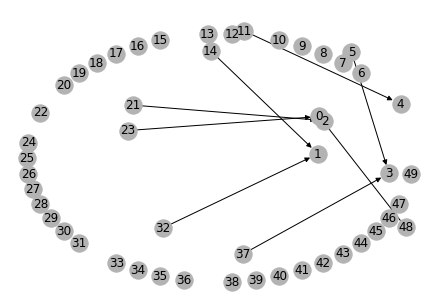

In [49]:
frontier_G = frontier.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(frontier_G)
nx.draw(frontier_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [56]:
src, dst = dgl.sampling.sample_neighbors(g, range(5), fanout=2, edge_dir='in').all_edges()
frontier = dgl.graph((src, dst), num_nodes=g.number_of_nodes())
frontier

Graph(num_nodes=50, num_edges=8,
      ndata_schemes={}
      edata_schemes={})

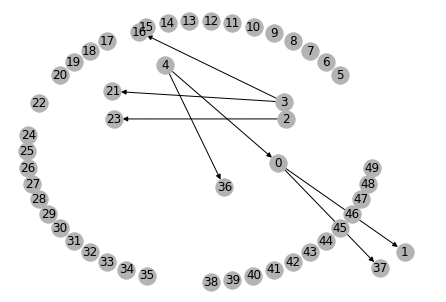

In [51]:
frontier_G = frontier.to_networkx()
# 为了图更加美观，我们使用Kamada-Kawaii layout 
pos = nx.kamada_kawai_layout(frontier_G)
nx.draw(frontier_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [123]:
for  batch in dataloader1:
    input_nodes, output_nodes, blocks = batch
    _batch = dataloader2.collator.collate(output_nodes)
    print(batch)
    print('=============')
    print(_batch)
    break

[tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14,  8, 46, 39, 28, 36,  1, 18, 31, 40, 19, 26, 30, 37, 20, 11, 29,  6, 49, 23, 34,  7, 21,  0,  2, 24,
         5,  3, 47,  4, 44, 41, 13, 17]), tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14]), [Block(num_src_nodes=43, num_dst_nodes=26, num_edges=71), Block(num_src_nodes=26, num_dst_nodes=10, num_edges=19)]]
(tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14,  6,  8, 46, 31, 39, 49, 20, 23, 28, 36,  1, 18, 40, 19, 34,  5,  7, 26, 30, 37, 41,  2, 11, 21, 29,
        43,  0, 24, 38,  3, 17, 32, 33, 44, 35, 47,  4, 16, 13]), tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14]), [Block(num_src_nodes=49, num_dst_nodes=35, num_edges=144), Block(num_src_nodes=35, num_dst_nodes=10, num_edges=36)])


In [ ]:
# for  batch in dataloader2:
#     input_nodes, output_nodes, blocks = batch
#     _batch = dataloader2.collator.collate(output_nodes)
#     print(batch, _batch, output_nodes)
#     break

In [13]:
# for input_nodes, seeds, blocks in dataloader:
#     print(input_nodes, seeds, blocks)
#     break

tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14, 39, 36, 40, 34, 20, 30, 29, 18,
        19, 37, 49,  3, 24, 31,  8, 23, 26,  2, 46, 13,  4, 47, 43, 28]) tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14]) [Block(num_src_nodes=34, num_dst_nodes=24, num_edges=47), Block(num_src_nodes=24, num_dst_nodes=17, num_edges=17), Block(num_src_nodes=17, num_dst_nodes=10, num_edges=10)]


In [14]:
import torch

In [15]:
blocks = sampler.sample_blocks(g,torch.tensor(train_nid[:10]))

In [16]:
block1 = blocks[0]
block2 = blocks[1]
block3 = blocks[2]

In [17]:
NID = '_ID'
output_nodes = blocks[-1].dstdata[NID]
input_nodes = blocks[0].srcdata[NID]
output_nodes, input_nodes

(tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14]),
 tensor([27, 22, 12, 25, 10, 45, 15,  9, 42, 14, 31, 20, 40, 34, 30, 11, 39, 19,
         37, 29, 28, 43,  1, 46,  6, 49, 36, 41,  2, 23,  3, 26, 24]))

In [18]:
a = torch.randn((5,5))
b = a+torch.randn(5,5)/10
a,b

(tensor([[-1.4225,  1.2862,  1.4382, -0.8791, -0.8470],
         [ 0.5994, -0.1194, -1.9005, -0.6214,  0.4100],
         [-1.3734,  0.5315,  0.1602, -1.5657, -1.3003],
         [-0.0180, -0.6553, -0.9826,  0.1842, -0.0776],
         [ 0.0438, -0.9161,  0.2776,  0.3127, -0.0883]]),
 tensor([[-1.4123,  1.2701,  1.3763, -1.0814, -0.7144],
         [ 0.4712,  0.0060, -2.0003, -0.8170,  0.3900],
         [-1.2875,  0.5673,  0.2179, -1.5130, -1.2226],
         [ 0.0869, -0.6660, -1.0720, -0.2188, -0.1397],
         [-0.2417, -0.8447,  0.4174,  0.3565,  0.0494]]))

In [19]:
out = torch.cat((a,b),dim=0)
out

tensor([[-1.4225,  1.2862,  1.4382, -0.8791, -0.8470],
        [ 0.5994, -0.1194, -1.9005, -0.6214,  0.4100],
        [-1.3734,  0.5315,  0.1602, -1.5657, -1.3003],
        [-0.0180, -0.6553, -0.9826,  0.1842, -0.0776],
        [ 0.0438, -0.9161,  0.2776,  0.3127, -0.0883],
        [-1.4123,  1.2701,  1.3763, -1.0814, -0.7144],
        [ 0.4712,  0.0060, -2.0003, -0.8170,  0.3900],
        [-1.2875,  0.5673,  0.2179, -1.5130, -1.2226],
        [ 0.0869, -0.6660, -1.0720, -0.2188, -0.1397],
        [-0.2417, -0.8447,  0.4174,  0.3565,  0.0494]])

In [20]:
temperature = 0.5
sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / temperature)
sim_matrix

tensor([[1.9306e+06, 8.4087e-04, 4.3968e+04, 9.5271e-03, 1.2454e-01, 1.7169e+06,
         1.8309e-03, 3.5614e+04, 1.2004e-02, 3.6971e-01],
        [8.4087e-04, 8.7733e+03, 2.2258e-01, 3.5783e+01, 2.8799e-01, 1.5498e-03,
         1.3385e+04, 1.9607e-01, 8.9584e+01, 1.2528e-01],
        [4.3968e+04, 2.2258e-01, 3.1920e+05, 2.6257e-01, 1.7293e-01, 5.4995e+04,
         6.8085e-01, 1.8476e+05, 7.8536e-01, 2.6048e-01],
        [9.5271e-03, 3.5783e+01, 2.6257e-01, 1.7648e+01, 2.1872e+00, 9.9878e-03,
         3.4636e+01, 2.2462e-01, 1.8497e+01, 1.5206e+00],
        [1.2454e-01, 2.8799e-01, 1.7293e-01, 2.1872e+00, 7.7502e+00, 1.0677e-01,
         1.9012e-01, 1.7178e-01, 1.6832e+00, 7.1882e+00],
        [1.7169e+06, 1.5498e-03, 5.4995e+04, 9.9878e-03, 1.0677e-01, 1.7309e+06,
         3.6539e-03, 4.4225e+04, 1.4769e-02, 3.1486e-01],
        [1.8309e-03, 1.3385e+04, 6.8085e-01, 3.4636e+01, 1.9012e-01, 3.6539e-03,
         2.4000e+04, 5.7144e-01, 1.0058e+02, 8.6130e-02],
        [3.5614e+04, 1.9607

In [21]:
mask = (torch.ones_like(sim_matrix) - torch.eye(2 * 5, device=sim_matrix.device)).bool()
mask

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True, False,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True, False,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True, False,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True, False]])

In [22]:
torch.set_printoptions(
    precision=2,    # 精度，保留小数点后几位，默认4
    threshold=1000,
    edgeitems=3,
    linewidth=150,  # 每行最多显示的字符数，默认80，超过则换行显示
    profile=None,
    sci_mode=False  # 用科学技术法显示数据，默认True
)

In [23]:
sim_matrix = sim_matrix.masked_select(mask).view(2 * 5, -1)
sim_matrix

tensor([[    0.00, 43968.25,     0.01,     0.12, 1716948.38,     0.00, 35614.39,     0.01,     0.37],
        [    0.00,     0.22,    35.78,     0.29,     0.00, 13384.62,     0.20,    89.58,     0.13],
        [43968.25,     0.22,     0.26,     0.17, 54995.08,     0.68, 184760.52,     0.79,     0.26],
        [    0.01,    35.78,     0.26,     2.19,     0.01,    34.64,     0.22,    18.50,     1.52],
        [    0.12,     0.29,     0.17,     2.19,     0.11,     0.19,     0.17,     1.68,     7.19],
        [1716948.38,     0.00, 54995.08,     0.01,     0.11,     0.00, 44224.61,     0.01,     0.31],
        [    0.00, 13384.62,     0.68,    34.64,     0.19,     0.00,     0.57,   100.58,     0.09],
        [35614.39,     0.20, 184760.52,     0.22,     0.17, 44224.61,     0.57,     0.64,     0.26],
        [    0.01,    89.58,     0.79,    18.50,     1.68,     0.01,   100.58,     0.64,     1.02],
        [    0.37,     0.13,     0.26,     1.52,     7.19,     0.31,     0.09,     0.26,     1

In [24]:
pos_sim = torch.exp(torch.sum(a * b, dim=-1) / temperature)
pos_sim

tensor([1716950.00, 13384.62, 184760.52,    18.50,     7.19])

In [25]:
pos_sim = torch.cat([pos_sim, pos_sim], dim=0)
pos_sim

tensor([1716950.00, 13384.62, 184760.52,    18.50,     7.19, 1716950.00, 13384.62, 184760.52,    18.50,     7.19])

In [26]:
result = (- torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()
result

tensor(0.59)

In [26]:
from torch.utils.data import DataLoader, Dataset
class IdDataSet(Dataset):

    def __init__(self, nid) -> None:
        self.nid = nid

    def __len__(self):
        return len(self.nid)

    def __getitem__(self, index):
        return self.nid[index]

In [27]:
class InOutDataIter:

    def __init__(self, id_dataloader):
        self.id_dataloader = iter(id_dataloader)

    def __next__(self):
        seeds = next(self.id_dataloader)
        return seeds

    def __len__(self):
        return len(self.id_dataloader)

In [44]:
class InOutDataLaoder:

    def __init__(self, nid, batch_size, shuffle) -> None:
        self.id_dataloader = DataLoader(IdDataSet(nid=nid), batch_size=batch_size, shuffle=shuffle)

    # 该方法必须返回一个迭代器
    def __iter__(self):
        return InOutDataIter(self.id_dataloader)
    
    def __len__(self):
        return len(self.id_dataloader)


In [45]:
a = torch.randint(0,20,(20,))
a

tensor([ 0, 14, 11,  0, 16, 17, 15, 16, 16,  2, 18, 13,  5,  9, 10,  8,  5,  0,
         5,  6])

In [46]:
d = InOutDataLaoder(a,2,True)

In [47]:
for i in enumerate(d):
    print(i)

(0, tensor([ 0, 11]))
(1, tensor([ 5, 10]))
(2, tensor([ 6, 17]))
(3, tensor([13, 18]))
(4, tensor([16, 16]))
(5, tensor([15,  9]))
(6, tensor([8, 2]))
(7, tensor([14,  5]))
(8, tensor([ 0, 16]))
(9, tensor([0, 5]))


In [48]:
len(d)

10